In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
df = pd.read_csv("Fraud_Analysis_Dataset.csv")

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


In [13]:
# Get counts and percentages
fraud_counts = df["isFraud"].value_counts()
fraud_percentages = df["isFraud"].value_counts(normalize=True) * 100

# Print results
print(f"Non-Fraud: {fraud_counts[0]} transactions ({fraud_percentages[0]:.1f}%)")
print(f"Fraud:     {fraud_counts[1]} transactions ({fraud_percentages[1]:.1f}%)")


Non-Fraud: 10000 transactions (89.8%)
Fraud:     1142 transactions (10.2%)


In [14]:
df = pd.read_csv("Fraud_Analysis_Dataset.csv")

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
import pandas as pd

In [16]:
# Define target and features
y = df["isFraud"]
X = df.drop(columns=['isFraud', 'nameOrig', 'nameDest', 'step', 'type'])  # dropped based on earlier decisions

# Identify numeric and categorical columns
numeric = X.select_dtypes(include='number').columns.tolist()
categorical = X.select_dtypes(include='object').columns.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [17]:
print(f"Shape of x_train: {X_train.shape}")
print("=" * 100)

print(f"Shape of x_test: {X_test.shape}")
print("=" * 100)

print(f"Shape of y_train: {y_train.shape}")
print("=" * 100)

print(f"Shape of y_test: {y_test.shape}")
print("=" * 100)

print("Original class distribution: \n", y.value_counts(normalize=True))
print("=" * 100)

print("Training set class distribution: \n", y_train.value_counts(normalize=True))
print("=" * 100)

print("Test set class distribution: \n", y_test.value_counts(normalize=True))
print("=" * 100)


Shape of x_train: (8913, 5)
Shape of x_test: (2229, 5)
Shape of y_train: (8913,)
Shape of y_test: (2229,)
Original class distribution: 
 isFraud
0    0.897505
1    0.102495
Name: proportion, dtype: float64
Training set class distribution: 
 isFraud
0    0.897453
1    0.102547
Name: proportion, dtype: float64
Test set class distribution: 
 isFraud
0    0.897712
1    0.102288
Name: proportion, dtype: float64


In [21]:
# Preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric),
    ("cat", OneHotEncoder(drop="first", handle_unknown='ignore'), categorical)
])

# Pipeline with LightGBM
pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", LGBMClassifier(random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 914, number of negative: 7999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 8913, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102547 -> initscore=-2.169241
[LightGBM] [Info] Start training from score -2.169241


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  [])])),
                ('clf', LGBMClassifier(random_state=42))])

In [23]:
y_pred = pipeline.predict(X_test)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2001
           1       0.96      0.96      0.96       228

    accuracy                           0.99      2229
   macro avg       0.98      0.98      0.98      2229
weighted avg       0.99      0.99      0.99      2229



In [28]:
confusion_matrix(y_test,y_pred)

array([[1991,   10],
       [   8,  220]], dtype=int64)

In [29]:
pipeline.score(X_test,y_test)

0.9919246298788694

In [30]:
import joblib

joblib.dump(pipeline,"fraud_detection_pipeline.pkl")

['fraud_detection_pipeline.pkl']

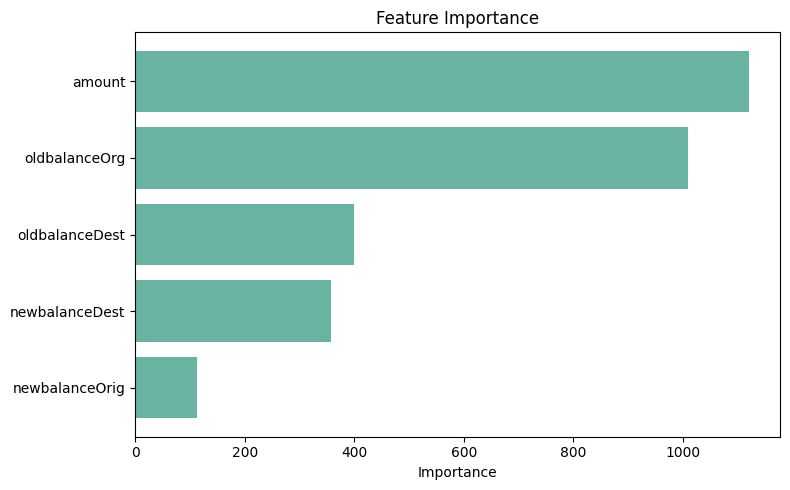

In [31]:
import joblib
pipeline = joblib.load("fraud_detection_pipeline.pkl")


model = pipeline.named_steps['clf']         # LightGBM model
preprocessor = pipeline.named_steps['prep'] # ColumnTransformer


# Extract feature names from the ColumnTransformer
feature_names = preprocessor.transformers_[0][2]  # ['amount', 'oldbalanceOrg', ...]

import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from the model
importances = model.feature_importances_

# Combine with names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='#69b3a2')
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
